In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import splitfolders
from PIL import Image
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Dropout, Flatten, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [2]:
os.listdir("./dataset")

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [3]:
base_dir = "./dataset"
splitfolders.ratio(base_dir, output="./data2", seed=42, ratio=(.8,.2))

train_dir = os.path.join("./data2", "train")
val_dir = os.path.join("./data2", "val")

In [4]:
def check_and_remove_corrupt_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            try:
                img_path = os.path.join(root, file)
                img = Image.open(img_path)
                img.verify()
            except (IOError, SyntaxError, Image.UnidentifiedImageError) as e:
                print(f"File rusak ditemukan dan dihapus: {img_path}")
                os.remove(img_path)

check_and_remove_corrupt_images(train_dir)
check_and_remove_corrupt_images(val_dir)

print("Pemeriksaan dan penghapusan file rusak selesai.")

Pemeriksaan dan penghapusan file rusak selesai.


In [5]:
train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1/255.0)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size = 32,
    class_mode = "categorical"
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size = 32,
    class_mode = "categorical"
)

Found 3372 images belonging to 4 classes.
Found 845 images belonging to 4 classes.


In [6]:
reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss', factor=0.1, patience=5, verbose=0, mode='auto',
                    min_delta=0.0001, cooldown=3, min_lr=1e-8
                )

In [7]:
pre_trained_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
pre_trained_model.trainable = False

In [8]:
model = Sequential([
    pre_trained_model,
    Flatten(),
    Dense(128, activation="relu"),
    Dense(4, activation="softmax")
])

In [9]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 17,926,596
Trainable params: 3,211,908
Non-trainable params: 14,714,688
_________________________________________________________________


In [11]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='Checkpoint_Percobaan_2.keras',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='auto'
)

In [12]:

early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, mode='auto', baseline=None, restore_best_weights=True)

In [13]:
history = model.fit(
    train_gen,
    epochs=100,
    validation_data = val_gen,
    verbose=1,
    callbacks=[reduce_on_plateau, early_stop, checkpoint]
)

Epoch 1/100
106/106 [==============================] - ETA: 0s - loss: 1.2392 - accuracy: 0.5845
Epoch 1: val_accuracy improved from -inf to 0.70533, saving model to Checkpoint_Percobaan_2.keras
106/106 [==============================] - 73s 603ms/step - loss: 1.2392 - accuracy: 0.5845 - val_loss: 0.7352 - val_accuracy: 0.7053 - lr: 0.0010
Epoch 2/100
106/106 [==============================] - ETA: 0s - loss: 0.5783 - accuracy: 0.7714
Epoch 2: val_accuracy improved from 0.70533 to 0.79053, saving model to Checkpoint_Percobaan_2.keras
106/106 [==============================] - 64s 608ms/step - loss: 0.5783 - accuracy: 0.7714 - val_loss: 0.5372 - val_accuracy: 0.7905 - lr: 0.0010
Epoch 3/100
106/106 [==============================] - ETA: 0s - loss: 0.4957 - accuracy: 0.8049
Epoch 3: val_accuracy improved from 0.79053 to 0.80355, saving model to Checkpoint_Percobaan_2.keras
106/106 [==============================] - 84s 791ms/step - loss: 0.4957 - accuracy: 0.8049 - val_loss: 0.4626 - va

1/1 [==============================] - 0s 51ms/step


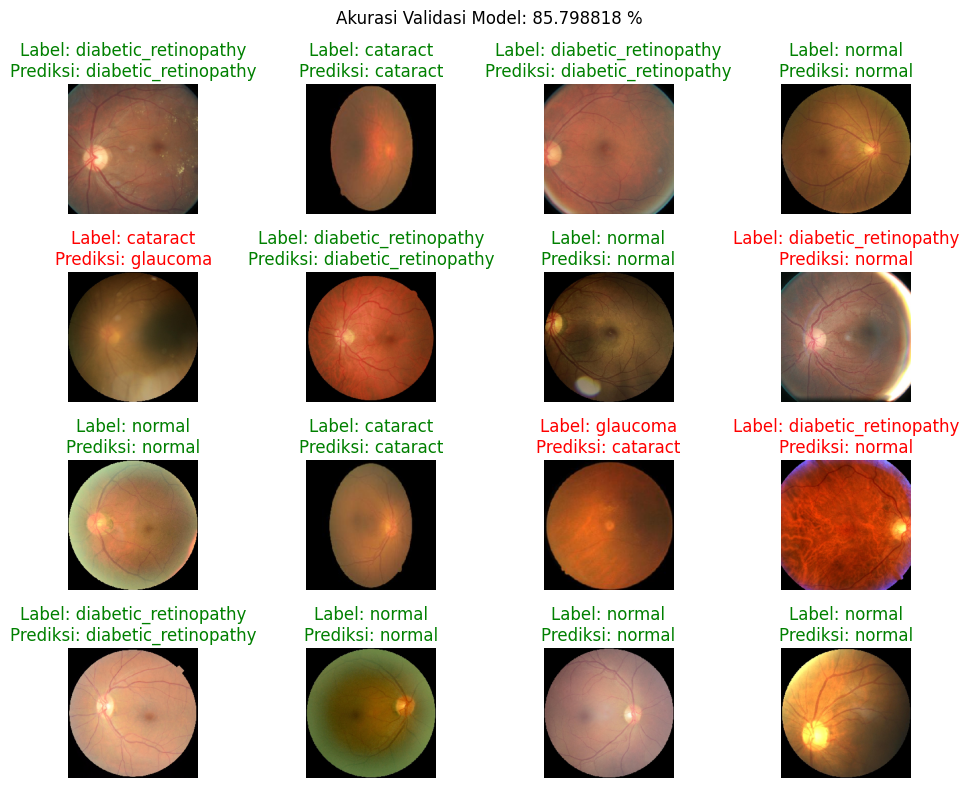

In [15]:
import numpy as np
import matplotlib.pyplot as plt

X_batch, y_batch = next(val_gen)

for img in X_batch:
    img = np.uint8(img)

preds = model.predict(X_batch)
pred_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(y_batch, axis=1)

daftar_label = ["cataract", "diabetic_retinopathy", "glaucoma", "normal"]
fig, axes = plt.subplots(4, 4, figsize=(10, 8))
loss, accuracy = model.evaluate(val_gen)
fig.suptitle("Akurasi Validasi Model: %f %%" % (accuracy*100))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_batch[i])
    ax.axis('off')

    true_label = daftar_label[true_classes[i]]
    pred_label = daftar_label[pred_classes[i]]

    font_color = 'green' if true_label == pred_label else 'red'

    ax.set_title(f"Label: {true_label}\nPrediksi: {pred_label}", color=font_color)

plt.tight_layout()
plt.show()

In [16]:
model.save("P2_85_7persen.keras")

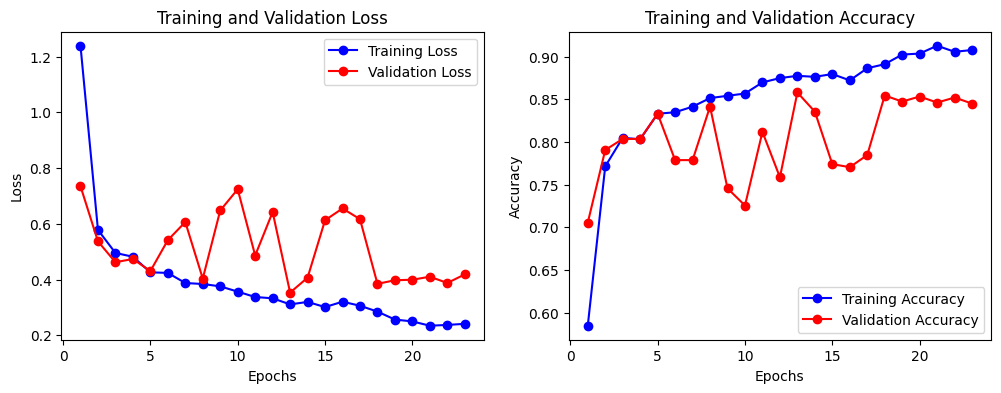

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()